## 1. Import packages

In [1]:
from subfunctions import *
from tqdm import tqdm

# DOE - sensitivity analysis

In [2]:
df_all = {}
bhps = [7250 + 100*i for i in range(10)]
molar_mass_s = [2.016, 4.0026, 16.1043, 30.07]
m_rhos = [14- 0.5*i for i in range(10)]
for bhp in tqdm(bhps):    
    for molar_mass in molar_mass_s:
        for m_rho in m_rhos:

            depth = 10_000 ##in ft
            pipe_ID = 4.25 ## inch
            pipe_OD = 5 ## inch
            openhole = 9.5 ## inch
            volume = 30  ## bbl 30 bbl 들어왔다고 가정
            molar_mass_methane = molar_mass ## g*mol^(-1)
            mass =  1_427_789.12 ## g, if density of kick = 2.5 ppg
            n = mass / molar_mass_methane
            T = 77 ## F, 섭씨 25도
            z = 1
            R = 8.314
            mu_p = 16 # in cp 
            tau_y = 8 # in lbf/100ft^2
            q = 100 # in gpm
            roughness = 0.000175 * 100 / 2.54 
            rel_roughness = roughness / pipe_ID
            Formation_temperature_grad = 2.0
            kick_height_from_bh = 0

            
            temp_well_before_kick_out = temperature_well_before_kick_out(T, Formation_temperature_grad, kick_height_from_bh)
            ID_c = inside_capacity(openhole, pipe_OD)
            f_depth_between = find_depth_between(ID_c, volume)
            kick_height_from_bh = 0

            P_k_b = Pressure_kick_bottom(kick_height_from_bh, bhp, m_rho)
            p_k_z = pressure_kick_z(volume, z, n, R, temp_well_before_kick_out)
            k_rho = compute_gas_density(z, R, temp_well_before_kick_out, molar_mass_methane, p_k_z)
            P_hy_bw = P_hy_between(k_rho, f_depth_between)
            P_k_m_r = P_kick_middle_r(P_k_b, P_hy_bw) 
            vel = velocity(q, openhole, pipe_OD)
            mu_a = apparent_viscosity(vel, openhole, pipe_OD, tau_y, mu_p)
            Re = reynolds(m_rho, vel, openhole, pipe_OD, mu_a)

            if Re > 4000:
                f = friction_factor(Re, rel_roughness)
                dP_per_dL = pressure_gradient_turbulent(f, m_rho, vel, openhole, pipe_OD)
            elif Re < 2100:
                dP_per_dL = pressure_gradient_laminar(mu_p, tau_y, vel, openhole, pipe_OD)
            else:
                assert False, "Again, we cannot solve this task as 2,100 < Re < 4,000"

            v_k_x = volume
            cal_f_depth_between = cal_find_depth_between(ID_c, v_k_x)

            depth_list = []
            Pressure_friction_list = []
            pressure_kick_top_list = []
            ch_pressure2_list = []
            kick_volume_list = []
            temp_well_before_kick_out_list = []
            t_list = []

            kick_height_from_bh = 0
            step = 1

            while  depth > kick_height_from_bh and 10000-kick_height_from_bh > cal_f_depth_between:

                P_k_b = Pressure_kick_bottom(kick_height_from_bh, bhp, m_rho)
                volume_z = 0
                while abs(volume_z-volume) > 15:
                    v_k_x = volume
                    cal_f_depth_between = cal_find_depth_between(ID_c, v_k_x)
                    p_k_z = pressure_kick_z(volume, z, n, R, temp_well_before_kick_out)
                    k_rho = compute_gas_density(z, R, temp_well_before_kick_out, molar_mass_methane, p_k_z)
                    P_hy_bw = P_hy_between(k_rho, f_depth_between)
                    P_k_m_r = P_kick_middle_r(P_k_b, P_hy_bw)
                    volume_z = volume_kick_z(P_k_m_r, z, n, R, temp_well_before_kick_out)
                    t = time(vel, kick_height_from_bh)
                    temp_well_before_kick_out = temperature_well_before_kick_out(T, Formation_temperature_grad, kick_height_from_bh)

                    volume += 0.001

                cal_P_hy_bw = cal_P_hy_between(k_rho, cal_f_depth_between)
                cal_P_k_m_r = cal_P_kick_middle_r(P_k_b, cal_P_hy_bw)
                p_k_t = pressure_kick_top(cal_P_k_m_r, cal_P_hy_bw)
                ch_pressure2 = choke_pressure2(p_k_t, m_rho, depth, dP_per_dL, kick_height_from_bh, cal_f_depth_between)
                t = time(vel, kick_height_from_bh)

                depth_list.append(kick_height_from_bh)
                pressure_kick_top_list.append(p_k_t)
                ch_pressure2_list.append(ch_pressure2)
                kick_volume_list.append(volume)
                t_list.append(t)
                temp_well_before_kick_out_list.append(temp_well_before_kick_out)
                kick_height_from_bh += step


            df_before_exit = pd.DataFrame({'kick_height_from_bh': depth_list, 
                                           'choke_pressure': ch_pressure2_list, 
                                           'methane_volume_when_go_surface_before': kick_volume_list,
                                           'time': t_list,
                                           'temperature_of_well': temp_well_before_kick_out_list})
            df_before_exit['depth'] = depth - df_before_exit['kick_height_from_bh']



            step = 0.1
            volume_kick_list = []
            cal_find_depth_between_list = []
            choke_pressure3_list = []
            temperature_well_to_during_kick_out_list = []
            t_2_list = []

            while v_k_x > 0:
                cal_f_depth_between = cal_find_depth_between(ID_c, v_k_x)
                t_2 = time2(t, vel, cal_f_depth_between)
                cal_P_hy_bw = cal_P_hy_between(k_rho, cal_f_depth_between)
                cal_P_k_m_r = cal_P_kick_middle_r(P_k_b, cal_P_hy_bw)
                p_k_t = pressure_kick_top(cal_P_k_m_r, cal_P_hy_bw)
                temp_well_to_during_kick_out = temperature_well_to_during_kick_out(T, Formation_temperature_grad, cal_f_depth_between)
                ch_pressure3 = choke_pressure3(p_k_t, m_rho, depth, dP_per_dL, kick_height_from_bh, cal_f_depth_between)


                volume_kick_list.append(v_k_x)
                cal_find_depth_between_list.append(cal_f_depth_between)
                choke_pressure3_list.append(ch_pressure3)
                t_2_list.append(t_2)
                temperature_well_to_during_kick_out_list.append(temp_well_to_during_kick_out)
                v_k_x -= step

            t_2_list_reversed = list(reversed(t_2_list))

            df_after_exit = pd.DataFrame({'methane_volume_when_kick_go_surface': volume_kick_list,
                                          'depth_of_kick': cal_find_depth_between_list, 
                                          'choke_pressure3': choke_pressure3_list,
                                          'time2': t_2_list_reversed,
                                          'temperatrue_of_well': temperature_well_to_during_kick_out_list})


            df_1 = df_after_exit[['time2','methane_volume_when_kick_go_surface','choke_pressure3']]
            df_0 = df_before_exit[['time','methane_volume_when_go_surface_before', 'choke_pressure']]
            df_0 = df_0.rename(columns={"time":"time", "methane_volume_when_go_surface_before":"kick_volume", "choke_pressure":"choke_pressure" })
            df_1 = df_1.rename(columns={"time2":"time", "methane_volume_when_kick_go_surface":"kick_volume", "choke_pressure3":"choke_pressure" })
            df = pd.concat([df_0,df_1], axis = 0).reset_index()
            
            name_for_results = f'bhp:{bhp}, molar_mass:{molar_mass}, m_rho: {m_rho}'
            df_all[name_for_results] = df

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:49<00:00, 34.92s/it]


## LinearRegression Inputs about max kick voulme and max choke pressure DOE

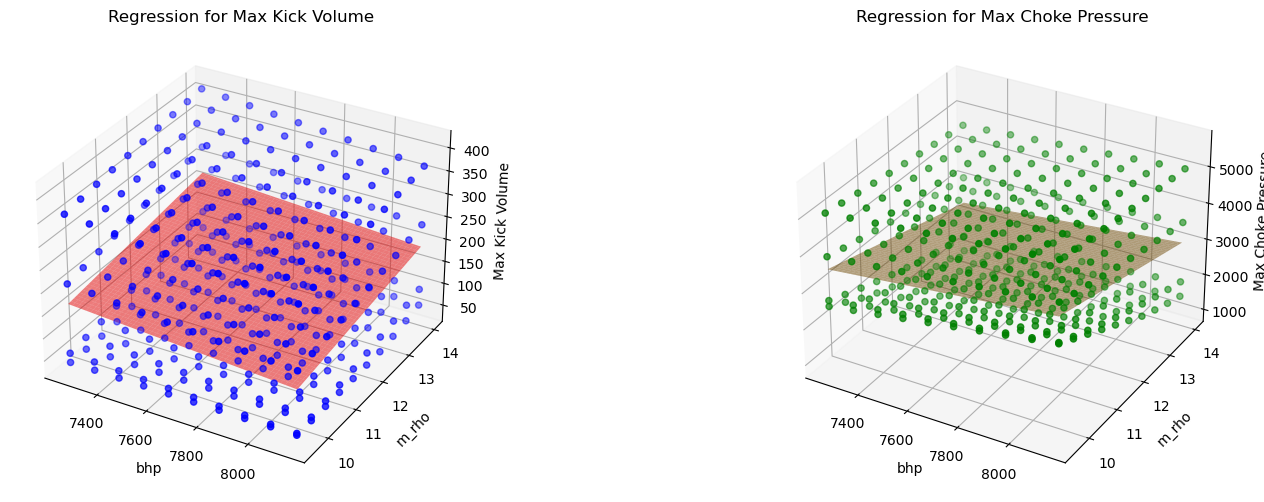

In [3]:
max_choke_pressures = []
max_kick_volumes = []
corresponding_bhps = []
corresponding_m_rhos = []
corresponding_molar_masses = []

for key, df in df_all.items():
    parameters = key.split(', ')
    bhp = float(parameters[0].split(':')[1])
    molar_mass = float(parameters[1].split(':')[1])
    m_rho = float(parameters[2].split(':')[1])
    
    max_choke_pressure = df['choke_pressure'].max()
    max_kick_volume = df['kick_volume'].max()
    
    max_choke_pressures.append(max_choke_pressure)
    max_kick_volumes.append(max_kick_volume)
    corresponding_bhps.append(bhp)
    corresponding_m_rhos.append(m_rho)
    corresponding_molar_masses.append(molar_mass)

X_multi_kick = np.array(list(zip(corresponding_bhps, corresponding_m_rhos, corresponding_molar_masses)))
reg_multi_kick = LinearRegression().fit(X_multi_kick, max_kick_volumes)

X_multi_choke = np.array(list(zip(corresponding_bhps, corresponding_m_rhos, corresponding_molar_masses)))
reg_multi_choke = LinearRegression().fit(X_multi_choke, max_choke_pressures)

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(corresponding_bhps, corresponding_m_rhos, max_kick_volumes, color='blue', label='Actual Data')

x_surf_kick, y_surf_kick = np.meshgrid(np.linspace(min(corresponding_bhps), max(corresponding_bhps), 100), 
                                     np.linspace(min(corresponding_m_rhos), max(corresponding_m_rhos), 100))
ax1.plot_surface(x_surf_kick, y_surf_kick, 
                reg_multi_kick.intercept_ + reg_multi_kick.coef_[0]*x_surf_kick + reg_multi_kick.coef_[1]*y_surf_kick + reg_multi_kick.coef_[2]*np.mean(corresponding_molar_masses), 
                color='red', alpha=0.5)

ax1.set_xlabel('bhp')
ax1.set_ylabel('m_rho')
ax1.set_zlabel('Max Kick Volume')
ax1.set_title('Regression for Max Kick Volume')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(corresponding_bhps, corresponding_m_rhos, max_choke_pressures, color='green', label='Actual Data')

x_surf_choke, y_surf_choke = np.meshgrid(np.linspace(min(corresponding_bhps), max(corresponding_bhps), 100), 
                                     np.linspace(min(corresponding_m_rhos), max(corresponding_m_rhos), 100))
ax2.plot_surface(x_surf_choke, y_surf_choke, 
                reg_multi_choke.intercept_ + reg_multi_choke.coef_[0]*x_surf_choke + reg_multi_choke.coef_[1]*y_surf_choke + reg_multi_choke.coef_[2]*np.mean(corresponding_molar_masses), 
                color='orange', alpha=0.5)

ax2.set_xlabel('bhp')
ax2.set_ylabel('m_rho')
ax2.set_zlabel('Max Choke Pressure')
ax2.set_title('Regression for Max Choke Pressure')

plt.show()

## Scatter Plot and Coeficient Of Determination 

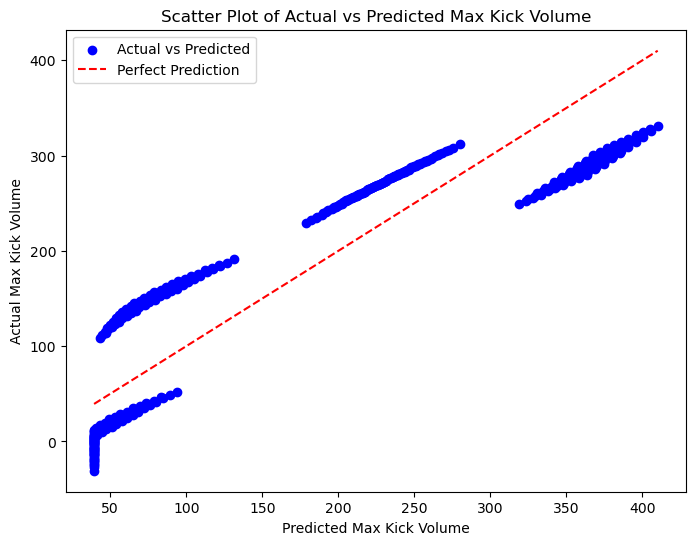

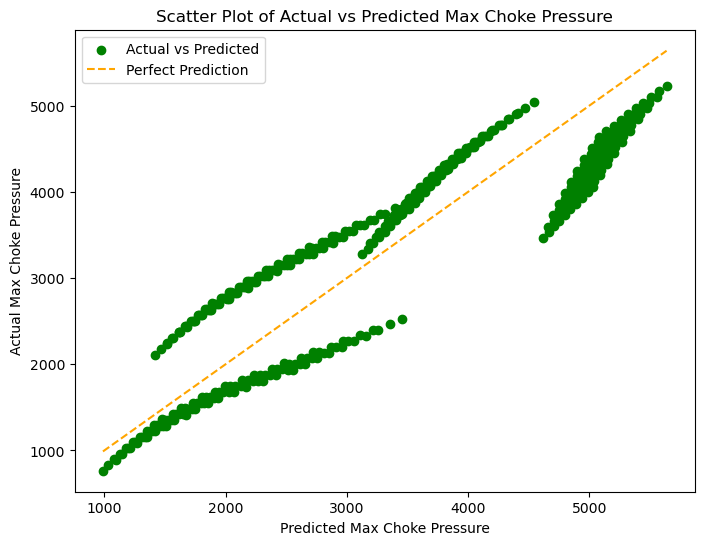

Max Kick Volume:
R-squared: 0.7828432457694785

Max Choke Pressure:
R-squared: 0.7920422162422807


In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
predicted_kick_volumes = reg_multi_kick.predict(X_multi_kick)

ax.scatter(max_kick_volumes, predicted_kick_volumes, color='blue', label='Actual vs Predicted')
ax.plot([min(max_kick_volumes), max(max_kick_volumes)], [min(max_kick_volumes), max(max_kick_volumes)], color='red', linestyle='--', label='Perfect Prediction')

ax.set_xlabel('Predicted Max Kick Volume')
ax.set_ylabel('Actual Max Kick Volume')
ax.set_title('Scatter Plot of Actual vs Predicted Max Kick Volume')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
predicted_choke_pressures = reg_multi_choke.predict(X_multi_choke)

ax.scatter(max_choke_pressures, predicted_choke_pressures, color='green', label='Actual vs Predicted')
ax.plot([min(max_choke_pressures), max(max_choke_pressures)], [min(max_choke_pressures), max(max_choke_pressures)], color='orange', linestyle='--', label='Perfect Prediction')

ax.set_xlabel('Predicted Max Choke Pressure')
ax.set_ylabel('Actual Max Choke Pressure')
ax.set_title('Scatter Plot of Actual vs Predicted Max Choke Pressure')
ax.legend()
plt.show()

r2_kick = r2_score(max_kick_volumes, predicted_kick_volumes)
r2_choke = r2_score(max_choke_pressures, predicted_choke_pressures)

print("Max Kick Volume:")
print("R-squared:", r2_kick)

print("\nMax Choke Pressure:")
print("R-squared:", r2_choke)

## T-test with nomalizing inputs

In [5]:
normalized_bhps, normalized_m_rhos, normalized_molar_masses = normalize_data(corresponding_bhps, corresponding_m_rhos, corresponding_molar_masses)
t_test_results = perform_t_tests_kick_volume((normalized_bhps, normalized_m_rhos, normalized_molar_masses), max_kick_volumes)
t_test_df_1 = pd.DataFrame(t_test_results)

for result in t_test_results:
    t_test_df_1

t_test_results = perform_t_tests_choke_pressure((normalized_bhps, normalized_m_rhos, normalized_molar_masses), max_choke_pressures)
t_test_df_2 = pd.DataFrame(t_test_results)

for result in t_test_results:
    t_test_df_2

df_every = pd.concat([t_test_df_1,t_test_df_2])
df_every
## t-value 값이 음수면 해당 그룹의 평균이 다른 그룹의 평균보다 작다라는 것을 나타냄
##  t-value가 음수인 경우는 두 번째 그룹의 평균이 더 크다는 것을 의미합니다.

Most influential variable about max kick volume: m_rho
Most influential variable about max choke pressure: bhp


,Variable_kick_volume,T-statistic_kick_volume,P-value about max kick volume,Significance,Variable_choke_pressure,T-statistic_choke_pressure,P-value about max choke pressure
0,m_rho,-28.139056,8.974825e-97,Significant,NaN,NaN,NaN
1,bhp,-28.093745,1.376716e-96,Significant,NaN,NaN,NaN
2,molar_mass,-27.921255,7.032731e-96,Significant,NaN,NaN,NaN
0,NaN,NaN,NaN,Significant,bhp,-50.468158,2.592661e-175
1,NaN,NaN,NaN,Significant,m_rho,-50.451364,2.908195e-175
2,NaN,NaN,NaN,Significant,molar_mass,-50.430337,3.358093e-175
